### Notwendige Importe

In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Daten laden und vorbereiten

In [3]:
# data path
data_dir = 'flowers'
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Zeigt einige Beispielbilder aus vorbereiteten Daten

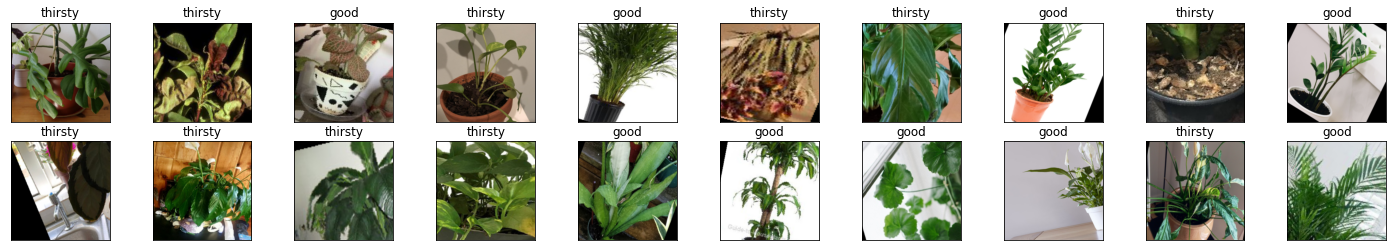

In [4]:
# specify the image classes
classes = ['good', 'thirsty']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))  # convert from Tensor image
    ax.set_title(classes[labels[idx]])

### Vor Trainiertes Modell herunterladen und anzeigen

In [5]:
model = models.densenet121(pretrained=True)
# model

### Frieren Sie vortrainierte Modelle ein

In [6]:
for param in model.parameters():
    param.requires_grad = False

### Den Klassifikator des vortrainierten Modells für unser Projekt Ändern

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Train Model

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10

valid_loss_average_min = np.Inf

for epoch in range(epochs):    
    valid_loss_average = 0.0 
    for inputs, labels in train_loader:
        steps += 1        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()            
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    valid_loss += batch_loss.item()                   
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item() 
            valid_loss_average = valid_loss/len(valid_loader)
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss_average:.3f}.. "
                  f"Valid accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            model.train()
            if valid_loss_average < valid_loss_average_min:
                print('Valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                      .format(valid_loss_average_min, valid_loss_average))
                torch.save(model.state_dict(), 'transferlearning_model_equal___.pt')
                valid_loss_average_min = valid_loss_average
 



## Load Model

In [16]:
model.load_state_dict(torch.load('transferlearning_model_equal_lr001.pt', 
                                 map_location=torch.device('cpu')
                                )
                     )

<All keys matched successfully>

## Test The Model

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.384086

Test Accuracy of  good: 96% (61/63)
Test Accuracy of thirsty: 73% (46/63)

Test Accuracy (Overall): 84% (107/126)
